In [273]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [274]:
data = pd.read_csv('icml_face_data.csv')

In [275]:
# convert pixels to array and normalize the data
data['pixels'] = data['pixels'].apply(lambda x: np.fromstring(x, sep=' '))
data['pixels'] = data['pixels'].apply(lambda x: x / 255.0)

# split data based on the second column
train_data = data[data['Usage'] == 'Training']
test_data_public = data[data['Usage'] == 'PublicTest']
test_data_private = data[data['Usage'] == 'PrivateTest']

# create training data
train_features = np.stack(train_data['pixels'].values)
train_labels = np.array(train_data['emotion'])

# test data
test_features = np.stack(test_data_public['pixels'].values)
test_labels = np.array(test_data_public['emotion'])

# validation data (not used)
val_features = np.stack(test_data_private['pixels'].values)
val_labels = np.array(test_data_private['emotion'])

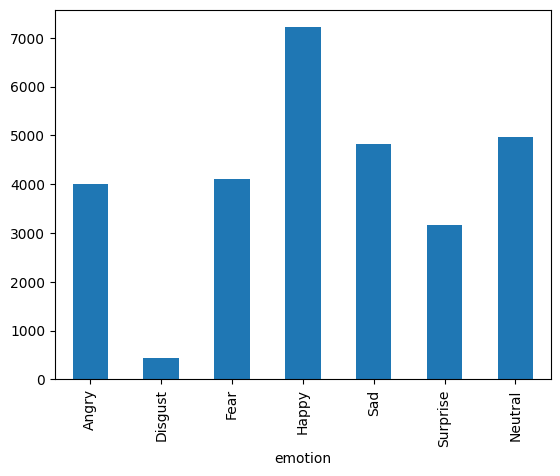

28709


In [287]:
# emotion distribution
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
td = train_data['emotion'].value_counts().sort_index()
td.plot(kind='bar')
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.show()

print(sum(train_data['emotion'].value_counts()))

In [277]:
# standardize data
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)
val_features_scaled = scaler.transform(val_features)

In [278]:
models = [None] * len(np.unique(train_labels))

# train a different model for each emotion
n_classes = len(np.unique(train_labels))
for i in range(n_classes):
    # create a binary label for each model
    binary_labels = np.where(train_labels == i, 1, -1)
        
    # train model
    model = RandomForestClassifier(n_estimators=200, random_state=1, n_jobs=-1)
    model.fit(train_features_scaled, binary_labels)
    models[i] = model

In [279]:
# predict probabilities for each model on the test set
y_pred_proba = np.zeros((test_features_scaled.shape[0], n_classes))
for i, model in enumerate(models):
    if model is not None:
        y_pred_proba[:, i] = model.predict_proba(test_features_scaled)[:, 1]
    else:
        y_pred_proba[:, i] = 0

# get predictions based on highest probability
y_pred = np.argmax(y_pred_proba, axis=1)
confidence_levels = np.max(y_pred_proba, axis=1)

# get second best prediction
sorted_indices = np.argsort(y_pred_proba, axis=1)
y_pred_second = sorted_indices[:, -2]
confidence_levels_second = np.take_along_axis(y_pred_proba, y_pred_second[:, np.newaxis], axis=1).flatten()

Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.22      0.31       467
           1       1.00      0.29      0.44        56
           2       0.56      0.26      0.36       496
           3       0.45      0.80      0.58       895
           4       0.43      0.39      0.41       653
           5       0.70      0.63      0.66       415
           6       0.44      0.43      0.43       607

    accuracy                           0.48      3589
   macro avg       0.58      0.43      0.46      3589
weighted avg       0.51      0.48      0.46      3589



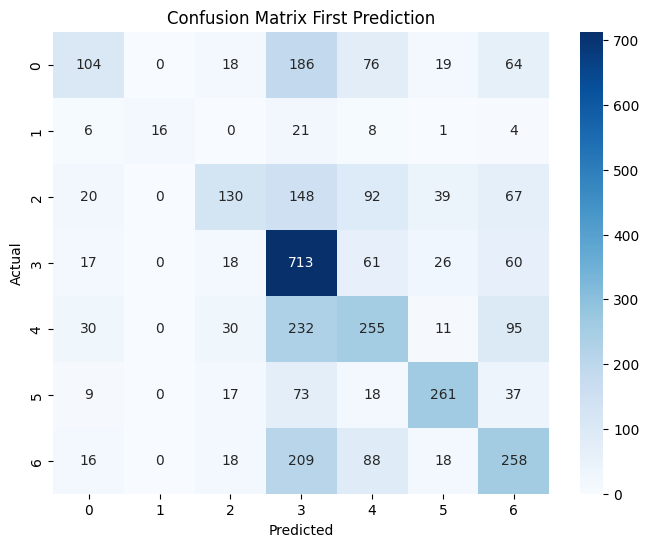

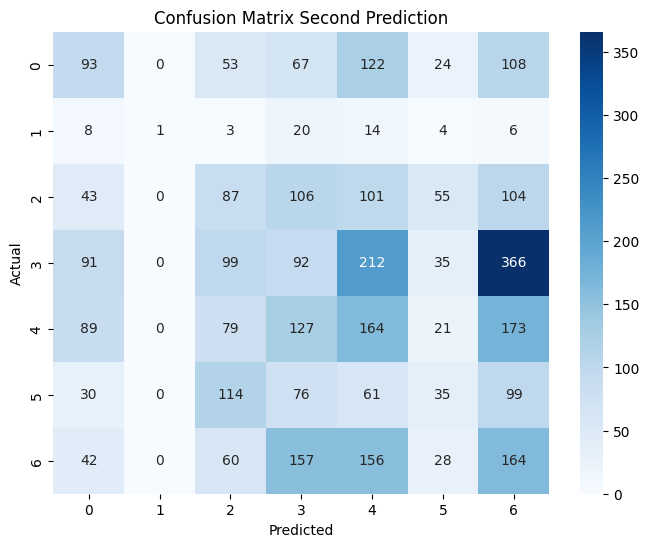

In [288]:
# classification report and confusion matrix
print("Classification Report:\n", classification_report(test_labels, y_pred))
conf_matrix = confusion_matrix(test_labels, y_pred)
conf_matrix_second = confusion_matrix(test_labels, y_pred_second)

# heatmap to visualize data
# correct predictions should weigh heavier on the diagonal
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix First Prediction')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_second, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Second Prediction')
plt.show()

In [281]:
label_names = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

# print confidence labels with labels
for i in range(len(test_labels)):
    print(f"True label: {label_names.get(test_labels[i])}, Predicted label: {label_names.get(y_pred[i])}, Confidence: {confidence_levels[i]:.4f}")

True label: Angry, Predicted label: Happy, Confidence: 0.4300
True label: Disgust, Predicted label: Happy, Confidence: 0.3100
True label: Sad, Predicted label: Sad, Confidence: 0.1950
True label: Neutral, Predicted label: Happy, Confidence: 0.3700
True label: Happy, Predicted label: Happy, Confidence: 0.5700
True label: Happy, Predicted label: Happy, Confidence: 0.6000
True label: Fear, Predicted label: Sad, Confidence: 0.2600
True label: Angry, Predicted label: Sad, Confidence: 0.2800
True label: Fear, Predicted label: Sad, Confidence: 0.3500
True label: Angry, Predicted label: Surprise, Confidence: 0.2408
True label: Happy, Predicted label: Happy, Confidence: 0.3700
True label: Angry, Predicted label: Surprise, Confidence: 0.2400
True label: Sad, Predicted label: Happy, Confidence: 0.2400
True label: Fear, Predicted label: Fear, Confidence: 0.2650
True label: Neutral, Predicted label: Neutral, Confidence: 0.3300
True label: Fear, Predicted label: Happy, Confidence: 0.3250
True label:

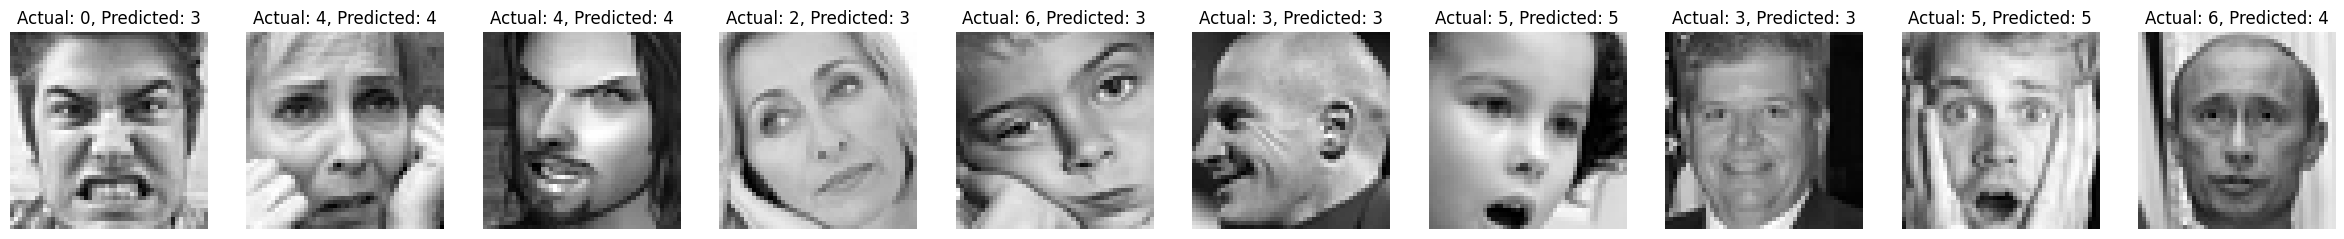

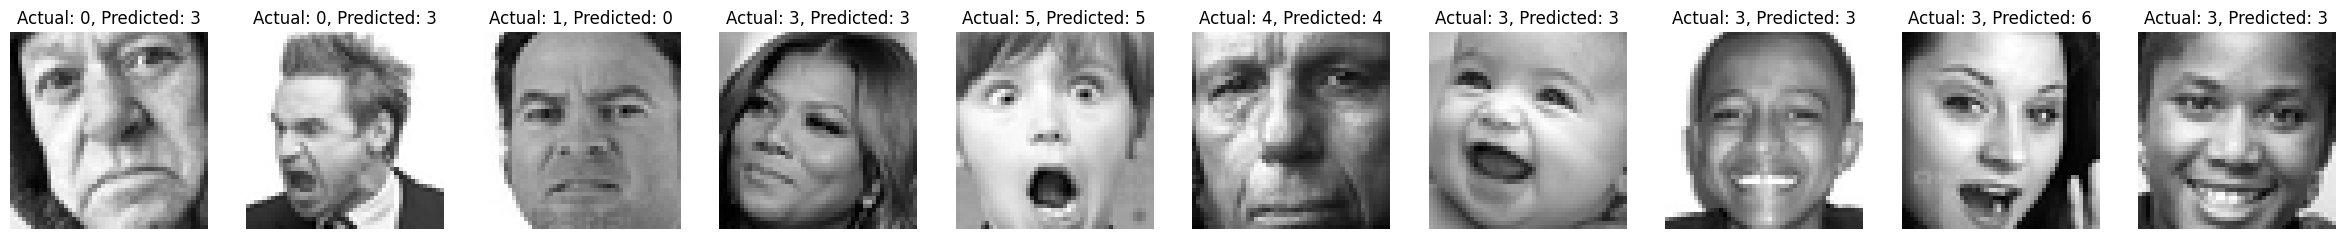

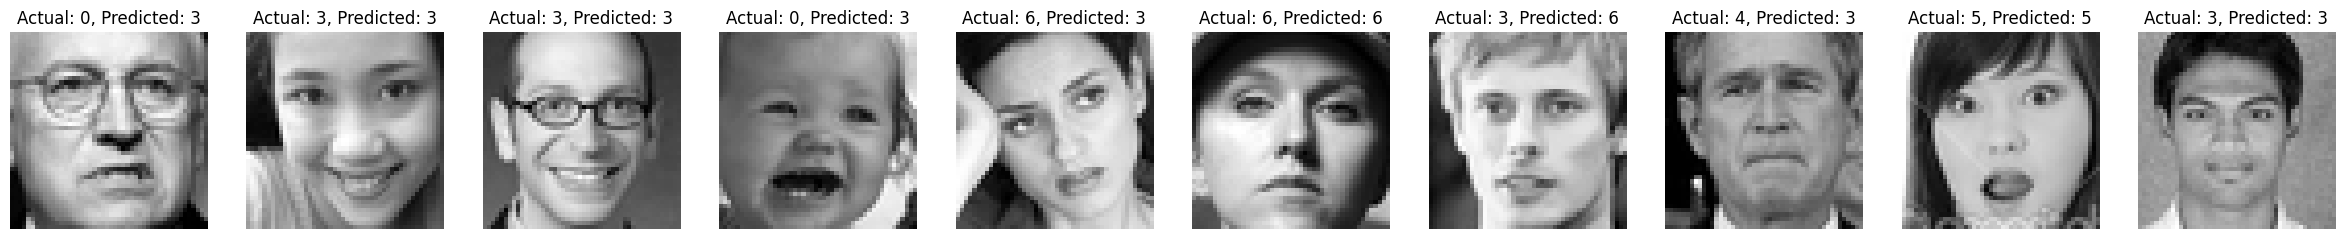

In [289]:
def plot_sample(images, labels, preds, n):
        plt.figure(figsize=(30, 8))
        for i in range(n):
            plt.subplot(1, n, i + 1)
            plt.imshow(images[i].reshape(48, 48), cmap='gray')
            plt.title(f"Actual: {labels[i]}, Predicted: {preds[i]}")
            plt.axis('off')
        plt.show()

def heatmap(data, title):
    sns.heatmap(data, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# plotting sample predictions
lower_bound = 40
upper_bound = 50

plot_sample(test_features[lower_bound:upper_bound], test_labels[lower_bound:upper_bound], y_pred[lower_bound:upper_bound], 10)
plot_sample(test_features[lower_bound*2:upper_bound*2], test_labels[lower_bound*2:upper_bound*2], y_pred[lower_bound*2:upper_bound*2], 10)
plot_sample(test_features[lower_bound*4:upper_bound*4], test_labels[lower_bound*4:upper_bound*4], y_pred[lower_bound*4:upper_bound*4], 10)

In [290]:
def analyze_correctness(confuse, classifier):
    correct = np.trace(confuse)
    incorrect = np.sum(confuse) - correct
    print(f"{classifier} correct classifications: {correct}")
    print(f"{classifier} incorrect classifications: {incorrect}")
    print(f"{classifier} rate of positives: {correct / (correct + incorrect)}\n")

print("Highest prediction:")
analyze_correctness(conf_matrix, "Random Forest Classification")
print("Second highest prediction:")
analyze_correctness(conf_matrix_second, "Random Forest Classification")

success_count = np.sum((test_labels == y_pred) | (test_labels == y_pred_second))
total_count = len(test_labels)
success_rate = success_count / total_count

print("Success rate of highest OR second highest:", success_rate)

Highest prediction:
Random Forest Classification correct classifications: 1737
Random Forest Classification incorrect classifications: 1852
Random Forest Classification rate of positives: 0.48397882418500976

Second highest prediction:
Random Forest Classification correct classifications: 636
Random Forest Classification incorrect classifications: 2953
Random Forest Classification rate of positives: 0.17720813597102256

Success rate of highest OR second highest: 0.6575647812761215


In [291]:
# merges equal values such as (Happy, Neutral) and (Neutral, Happy)
def merge_pair_counts(confusion_matrix):
    pair_counts = {}
    
    for i in range(confusion_matrix.shape[0]):
        for j in range(i + 1, confusion_matrix.shape[1]):
            pair = tuple(sorted((i, j)))
            if pair in pair_counts:
                pair_counts[pair] += confusion_matrix[i, j] + confusion_matrix[j, i]
            else:
                pair_counts[pair] = confusion_matrix[i, j] + confusion_matrix[j, i]

    return pair_counts

# matrix to count the pairs
classes = y_pred_proba.shape[1]
confusion_pair_counts = np.zeros((classes, classes), dtype=int)

# count occurences of labeled pairs
for pred, second_pred in zip(y_pred, y_pred_second):
    confusion_pair_counts[pred, second_pred] += 1

# find similar labels
most_similar_indices = np.unravel_index(np.argmax(confusion_pair_counts, axis=None), confusion_pair_counts.shape)
most_similar_labels = (most_similar_indices[0], most_similar_indices[1])
most_similar_count = confusion_pair_counts[most_similar_indices]
            
# find the labels that are most often confused and merges equal pairs
top_x_values = 10
merged_pair_counts = merge_pair_counts(confusion_pair_counts)
sorted_pairs = sorted(merged_pair_counts.items(), key=lambda x: x[1], reverse=True)

top_x_pairs = sorted_pairs[:top_x_values]
print(f"Top {top_x_values} most similar emotions:")
for pair, count in top_x_pairs:
    print(f"Emotions: {label_names.get(pair[0])} and {label_names.get(pair[1])}, Count: {count}")


Top 10 most similar emotions:
Emotions: Happy and Neutral, Count: 890
Emotions: Happy and Sad, Count: 635
Emotions: Sad and Neutral, Count: 389
Emotions: Fear and Happy, Count: 260
Emotions: Angry and Happy, Count: 231
Emotions: Angry and Sad, Count: 204
Emotions: Fear and Surprise, Count: 184
Emotions: Happy and Surprise, Count: 157
Emotions: Surprise and Neutral, Count: 140
Emotions: Fear and Sad, Count: 120
